# 5. Regularization vs Overfitting, Ridge Regression

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset generation

As in Notebook 3., we will generate prices $ y_i $ as a polynomial function  of the surface $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, will be defined as

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 5\% $ drift as before.

In [2]:
# All helper functions
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this has changed and is now a polynomial function.
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def generate_datasets(n_points, min_surf, max_surf):
    x = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    y = np.array([price(i) for i in x])
    return x, y
def linreg_matplotlib(a, b, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = a*x + b
    return x, y
def loss_mse(a, b, x, y):
    val =  np.sum((y - (a*x + b))**2)/x.shape[0]
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
min_surf = 40
max_surf = 150
np.random.seed(27)
n_points = 50
inputs, outputs = generate_datasets(n_points, min_surf, max_surf)
print(inputs)
print(outputs)

[ 86.83 129.6  120.89 135.48  82.17 147.74 138.25  63.07 121.6  112.95
 137.55 134.38 122.42 135.72  60.54  75.81  81.02 127.31  56.62  58.69
  48.93  73.57 126.16  57.92  47.77 117.12  59.91 105.88  85.68  96.49
  64.27 119.81 133.44 142.18 120.95  92.42  94.22 105.4   48.36  52.92
 146.31 104.17  50.17  41.5  132.06 140.63 117.5   82.57 117.63 141.56]
[ 3.171633  8.805667  7.166722 10.224944  3.195151 11.87205  10.206911
  1.676214  7.954078  5.696169 10.049157  9.588631  7.968783  8.827882
  1.693317  2.6239    3.094831  7.700582  1.597057  1.489182  1.247223
  2.166055  8.212138  1.627403  1.12722   6.560241  1.450404  5.072051
  3.031968  3.938955  1.782147  7.652644  8.58658  11.518957  7.088832
  3.563134  3.702923  5.087156  1.071143  1.308982 12.111945  5.438864
  1.088438  0.998857  9.333922  9.801835  7.095279  2.982004  6.953392
 11.129658]


### Train-Test Splitting

As in Notebook 4, we will use a basic train-test split, with a ratio of 80-20%.

In [4]:
# 80% of the samples will be used for training,
# and the remaining 20% will be used to evaluate generalization/overfitting.
ratio_train = 0.8
split_index = int(n_points*ratio_train)
# Training inputs and outputs
train_inputs = inputs[:split_index]
train_outputs = outputs[:split_index]
# Testing inputs and outputs
test_inputs = inputs[split_index:]
test_outputs = outputs[split_index:]

### Training an overfitting polynomial regressor.

As in Notebook 4, we will use a polynomial regressor with a degree higher than needed (6, instead of 3) and will reuse the helper functions we have introduced earlier.

In [5]:
# Training a Polynomial Regressor
n_degree = 6
sk_inputs = np.array(train_inputs).reshape(-1, 1)
sk_outputs = np.array(train_outputs)
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[-5.31103644e+00  1.55941662e-01 -2.34706297e-03  1.92370550e-05
 -8.12548986e-08  1.38734052e-10] 73.25495081585393


In [6]:
# Polynomial regression of the helper function that will
# help get points for the upcoming matplotlib displays.
def polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in x])
    return x, y

In [7]:
# Mean square error as a loss function for polynomial regression
# Displaying loss using exponential notation (XXXe-YYY)
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    pred = np.array([poly_reg_model.predict(np.array([[i**(j+1) for j in range(n_degree)]]))[0] for i in inputs])
    losses = (pred - outputs)**2
    val = sum(losses)/inputs.shape[0]
    return '{:.2e}'.format(val)

In [8]:
loss_train = loss_mse_poly(poly_reg_model, n_degree, train_inputs, train_outputs)
print(loss_train)
loss_test = loss_mse_poly(poly_reg_model, n_degree, test_inputs, test_outputs)
print(loss_test)

9.69e-02
1.60e-01


### Training a ridge regressor

Text

In [9]:
# Training a Polynomial Regressor with Regularization, aka as a Ridge model
n_degree2 = 6
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
ridge_reg = KernelRidge(alpha = 5e-1, kernel ='polynomial', degree = n_degree2)
ridge_reg.fit(sk_inputs2, sk_outputs2)
print(ridge_reg)

KernelRidge(alpha=0.5, degree=6, kernel='polynomial')


### Predicting with a ridge regressor

Text

In [10]:
# Helper function for prediction evaluation
# Return interval of min and max values, along with avg value for given surface
def theoretical_values(surface):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

In [11]:
# Predicting with model
new_surface = 121
out = ridge_reg.predict([[new_surface]])[0]
print(out, theoretical_values(new_surface))

7.253264170140028 [6.4384344, 7.153816, 7.869197600000001]


### Visualising the impact of overfitting on a ridge regressor

Text

In [12]:
def ridgereg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    x = np.linspace(min_surf, max_surf, n_points)
    y = np.array([poly_reg_model.predict(np.array([[i]]))[0] for i in x])
    return x, y

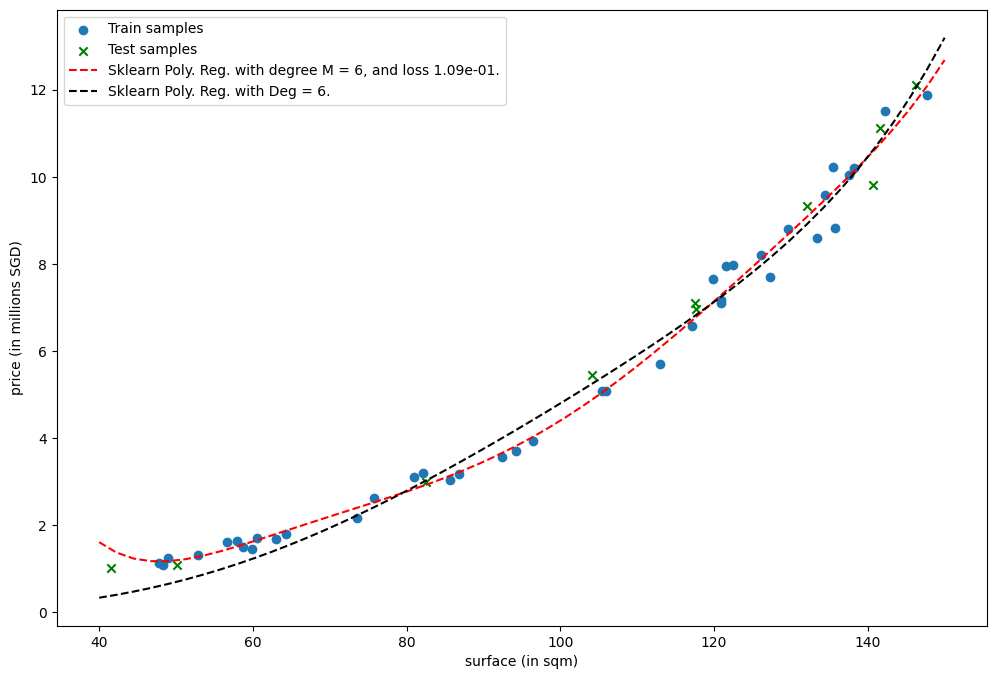

In [13]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'g', marker = "x", label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal poly reg (with degree M = 6)
polyreg_dataset1_inputs, polyreg_dataset1_outputs = polyreg_matplotlib(poly_reg_model, n_degree, min_surf, max_surf, n_points)
loss1 = loss_mse_poly(poly_reg_model, n_degree, inputs, outputs)
legend1 = "Sklearn Poly. Reg. with degree M = 6, and loss {}.".format(loss1)
plt.plot(polyreg_dataset1_inputs, polyreg_dataset1_outputs, 'r--', label = legend1)

# Optimal ridge reg (M = 6), to see how its regularization helps avoid overfitting
polyreg_dataset2_inputs, polyreg_dataset2_outputs = ridgereg_matplotlib(ridge_reg, n_degree2, min_surf, max_surf, n_points)
legend2 = "Sklearn Poly. Reg. with Deg = 6."
plt.plot(polyreg_dataset2_inputs, polyreg_dataset2_outputs, 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

### What's next?

In the next notebook, we will discuss how to move from linear regression to logistic regression for classification.